# Week 10 Relative Representations on images
In this notebook we will take a look at how relative representations can be used to use a model trained on one representation on another. The authors of the paper claim that the performance is excellent, so let's investigate!

Using 3 different pre-trained image recognition models from pytorch we remove the classification layer and simply flatten the output of the layer before. These are stored you will use them to train a classifier on the Cifar-10 dataset. In addition we create a set of relative representations using those same output with n_anchors=300. We have thus provided you with 6 datasets on which classification networks can be trained.

### Exercise 1 Absolute/Own representations
**1. Load the data**

In [1]:
import os
import torch
import torchvision.models as models_torch

from model_classes import FFNN
from train_function import train, test
from torchvision.models import MobileNet_V2_Weights, SqueezeNet1_0_Weights, ResNet50_Weights
from week_10.create_dataset import load_and_concatenate_batches

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
mobilenet = models_torch.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to(device)
squeezenet = models_torch.squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT).to(device)
resnet = models_torch.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

mobilenet.eval()
squeezenet.eval()
resnet.eval()
pass  # To stop the print that would otherwise occur

In [3]:
# Define models and dataset types
models = [mobilenet, squeezenet, resnet]
model_names = ["mobilenet", "squeezenet", "resnet"]
datasets = ["train", "val", "test"]

# Initialize a dictionary to store DataLoader objects
dataloaders_own_rep = {}

# Loop through each model and dataset type
for model, model_name in zip(models, model_names):
    for dataset_type in datasets:
        # Construct the file pattern for the current model and dataset (e.g., "data/rel_reps_mobilenet/train/batch_*.pth")
        split_folder = f"data/own_reps_{model_name}/{dataset_type}/"

        # Load data and create a DataLoader with all batches concatenated
        dl = load_and_concatenate_batches(split_folder)
        dataloaders_own_rep[f"{model_name}_{dataset_type}"] = dl
        temp = next(iter(dl))
        print(temp[0].shape, temp[1].shape)

C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_10\create_dataset.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_

torch.Size([32, 5120]) torch.Size([32])
torch.Size([32, 5120]) torch.Size([32])
torch.Size([32, 5120]) torch.Size([32])
torch.Size([32, 4608]) torch.Size([32])
torch.Size([32, 4608]) torch.Size([32])
torch.Size([32, 4608]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32])


In [4]:
# Now dataloaders contains DataLoader objects with all batches concatenated for each model and dataset
print(dataloaders_own_rep.keys())

dict_keys(['mobilenet_train', 'mobilenet_val', 'mobilenet_test', 'squeezenet_train', 'squeezenet_val', 'squeezenet_test', 'resnet_train', 'resnet_val', 'resnet_test'])


**2. In the next couple of cells you will train networks on the data, what results do you expect?**

In [10]:
model_mobilenet = FFNN(num_classes=10)
model_squeezenet = FFNN(num_classes=10)
model_resnet = FFNN(num_classes=10)
epochs = 3

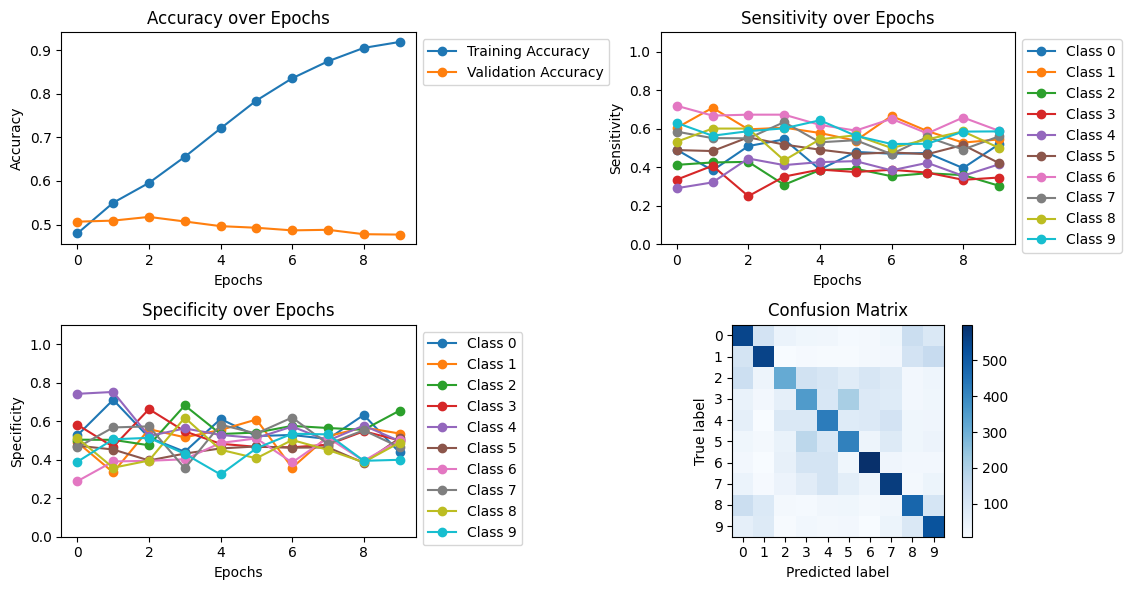

In [7]:
results_mobilenet_train = train(
    device=device,
    model=model_mobilenet,
    train_dataloader=dataloaders_own_rep["mobilenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_own_rep["mobilenet_val"],
    run_filepath="models/own_reps/mobilenet",
    plot=True,
    overwrite=False
)

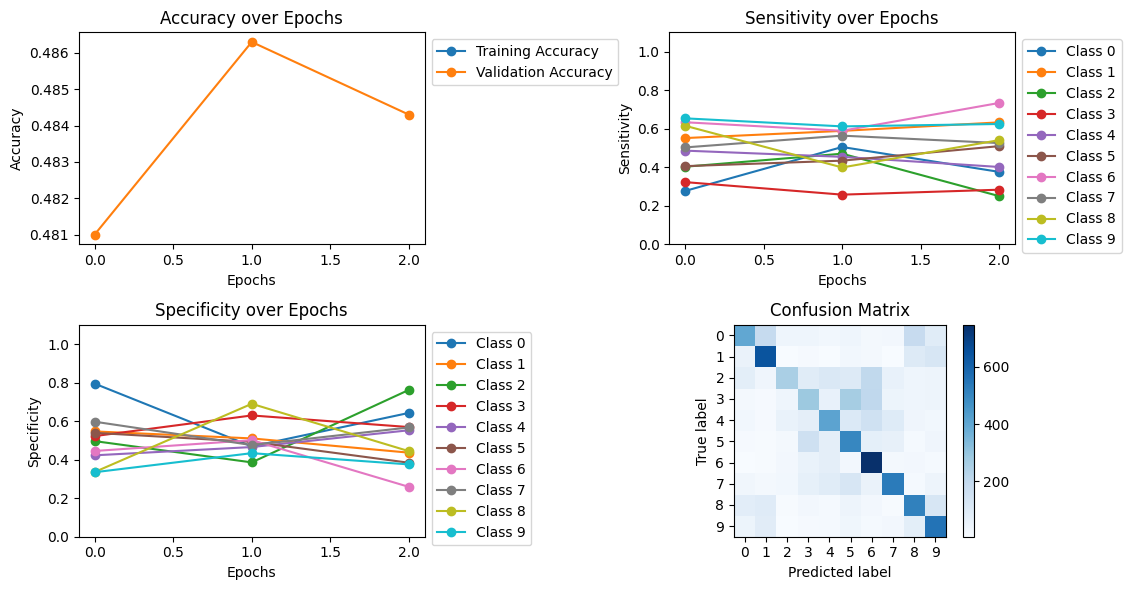

In [18]:
results_squeezenet_train = train(
    device=device,
    model=model_squeezenet,
    train_dataloader=dataloaders_own_rep["squeezenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_own_rep["squeezenet_val"],
    run_filepath="models/own_reps/squeezenet",
    plot=True,
    overwrite=False,
    in_notebook=True
)

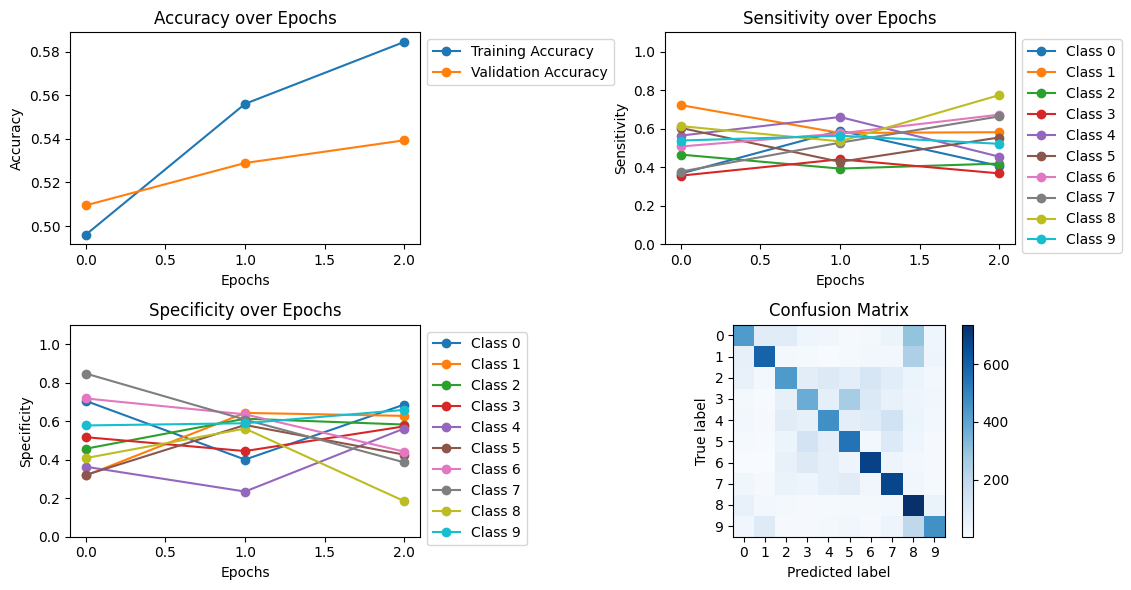

In [11]:
results_resnet_train = train(
    device=device,
    model=model_resnet,
    train_dataloader=dataloaders_own_rep["resnet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_own_rep["resnet_val"],
    run_filepath="models/own_reps/resnet",
    plot=True,
    overwrite=False,
    in_notebook=True
)

**3. We now want to compare the results of each model and specifically whether we can use a model trained on one dataset on another. Why/why not?**

In [22]:
from tabulate import tabulate   # use `!pip install tabulate` in a cell to get the library

acc_matrix = []
dataloader_names = [f"{model_name}_test" for model_name in model_names]

model_mobilenet.load_model("models/own_reps/mobilenet/2.pth")
model_squeezenet.load_model("models/own_reps/squeezenet/0.pth")
model_resnet.load_model("models/own_reps/resnet/2.pth")

for model in [model_mobilenet, model_squeezenet, model_resnet]:
    row = []
    for dataloader_name in dataloader_names:
        try:
            res = test(
            model=model,
            test_dataloader=dataloaders_own_rep[dataloader_name],
            device=device,
            plot=False
        )
        except RuntimeError:
            res = [[0]]
        row.append(res[0][0])
    acc_matrix.append(row)

headers = ['Model/Dataloader'] + dataloader_names
table_own_reps = [[model_name] + row for model_name, row in zip(model_names, acc_matrix)]

Model loaded from models/own_reps/mobilenet/2.pth
Model loaded from models/own_reps/squeezenet/0.pth
Model loaded from models/own_reps/resnet/2.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.5225
Test Sensitivity: [0.507 0.575 0.489 0.25  0.421 0.581 0.688 0.55  0.597 0.567]
Test Specificity: [0.49547739 0.5526658  0.45341615 0.67024129 0.54725898 0.39453861
 0.37187128 0.58214748 0.38824663 0.56233766]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4813
Test Sensitivity: [0.278 0.55  0.399 0.321 0.457 0.424 0.642 0.484 0.598 0.66 ]
Test Specificity: [0.77801724 0.54216867 0.47850318 0.51713633 0.42755906 0.55331412
 0.40774487 0.62621359 0.35765125 0.37362637]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.5433
Test Sensitivity: [0.393 0.587 0.435 0.362 0.425 0.586 0.688 0.654 0.785 0.518]
Test Specificity: [0.69850403 0.59941945 0.58127572 0.57685353 0.5738523  0.4198783
 0.42276423 0.39140271 0.17916667 0.7005814 ]


In [ ]:
# Print the table nicely
print(tabulate(table_own_reps, headers=headers, floatfmt=".4f", tablefmt="grid"))

### Exercise 2: Relative representations

**1. Run the same experiments on the relative representations**

In [2]:
mobilenet = models_torch.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to(device)
squeezenet = models_torch.squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT).to(device)
resnet = models_torch.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

mobilenet.eval()
squeezenet.eval()
resnet.eval()
pass    # To stop the print that would otherwise occur

In [3]:
# Define models and dataset types
models = [mobilenet, squeezenet, resnet]
model_names = ["mobilenet", "squeezenet", "resnet"]
datasets = ["train", "val", "test"]

# Initialize a dictionary to store DataLoader objects
dataloaders_rel_rep = {}

# Loop through each model and dataset type
for model, model_name in zip(models, model_names):
    for dataset_type in datasets:
        # Construct the file pattern for the current model and dataset (e.g., "data/rel_reps_mobilenet/train/batch_*.pth")
        split_folder = f"data/rel_reps_{model_name}/{dataset_type}/"
        
        # Load data and create a DataLoader with all batches concatenated
        dataloaders_rel_rep[f"{model_name}_{dataset_type}"] = load_and_concatenate_batches(split_folder)

C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_10\create_dataset.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_

In [4]:
# Now dataloaders_rel_rep contains DataLoader objects with all batches concatenated for each model and dataset
print(dataloaders_rel_rep.keys())

dict_keys(['mobilenet_train', 'mobilenet_val', 'mobilenet_test', 'squeezenet_train', 'squeezenet_val', 'squeezenet_test', 'resnet_train', 'resnet_val', 'resnet_test'])


In [8]:
model_mobilenet = FFNN(num_classes=10)
model_squeezenet = FFNN(num_classes=10)
model_resnet = FFNN(num_classes=10)

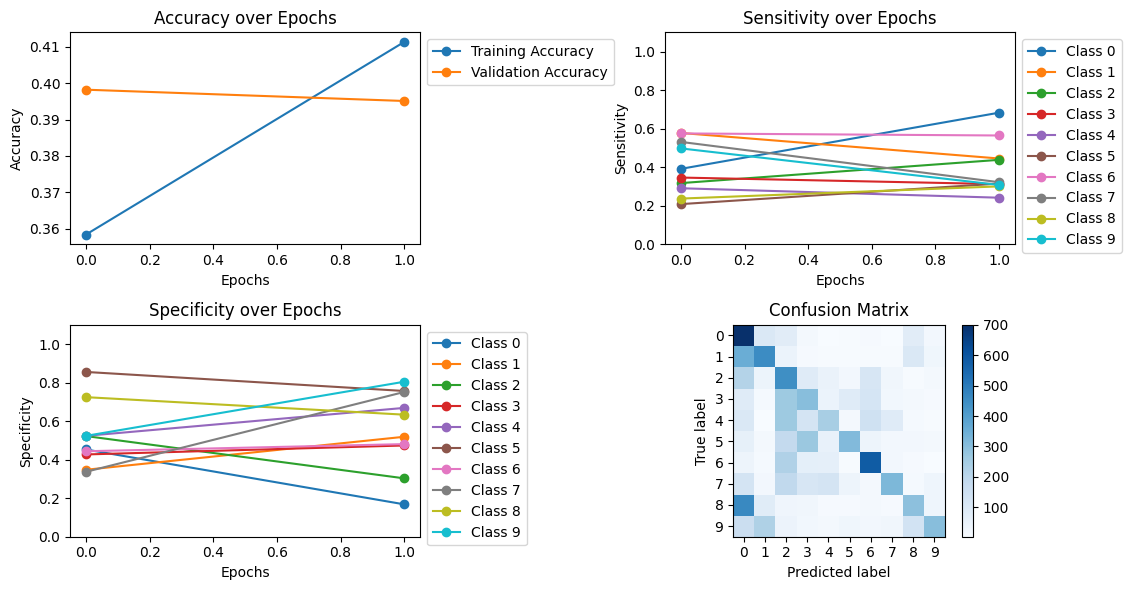

  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
epochs = 10
results_mobilenet_train = train(
    device=device,
    model=model_mobilenet,
    train_dataloader=dataloaders_rel_rep["mobilenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_rel_rep["mobilenet_val"],
    run_filepath="models/rel_reps/mobilenet",
    plot=True,
    overwrite=True
)

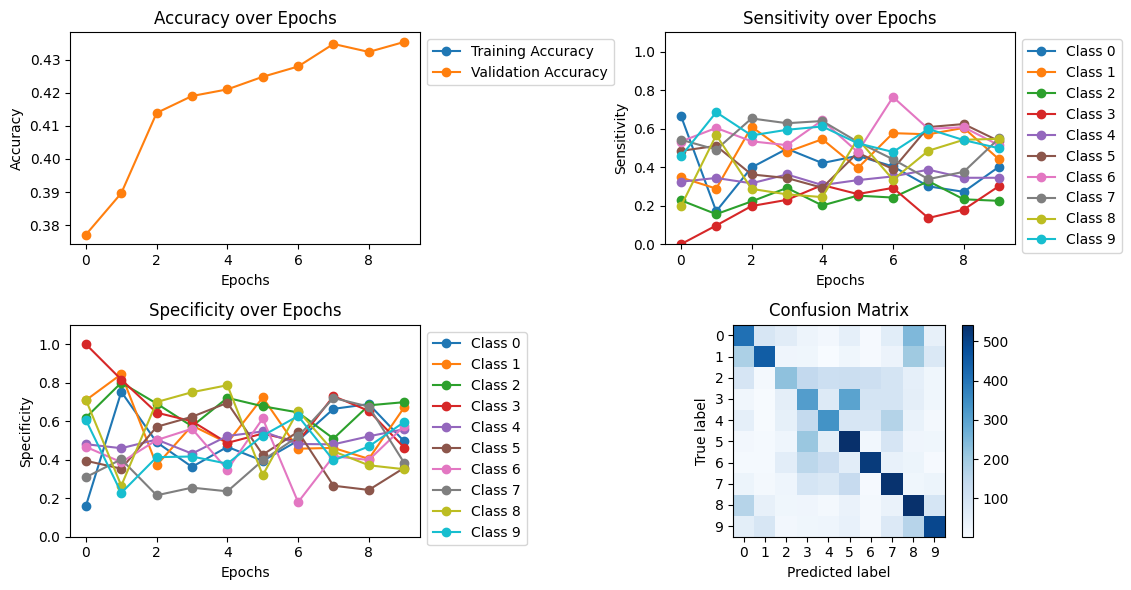

In [8]:
results_squeezenet_train = train(
    device=device,
    model=model_squeezenet,
    train_dataloader=dataloaders_rel_rep["squeezenet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_rel_rep["squeezenet_val"],
    run_filepath="models/rel_reps/squeezenet",
    plot=True,
    overwrite=False,
    in_notebook=True
)

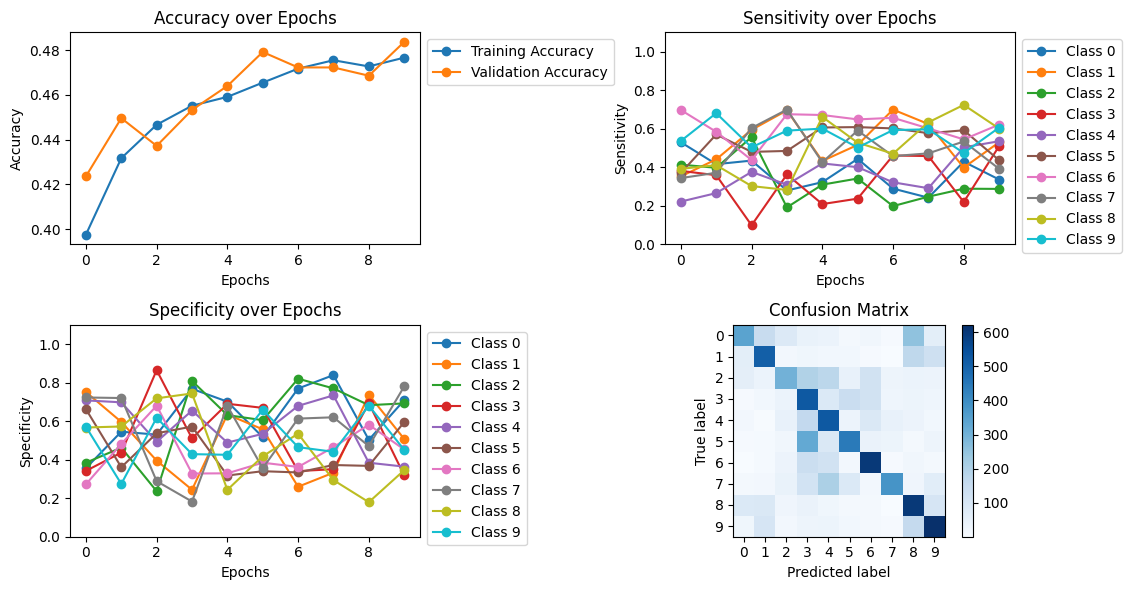

In [11]:
results_resnet_train = train(
    device=device,
    model=model_resnet,
    train_dataloader=dataloaders_rel_rep["resnet_train"],
    epochs=epochs,
    val_dataloader=dataloaders_rel_rep["resnet_val"],
    run_filepath="models/rel_reps/resnet",
    plot=True,
    overwrite=False,
    in_notebook=True
)

In [27]:
from tabulate import tabulate

acc_matrix = []
dataloader_names =  [f"{model_name}_test" for model_name in model_names]

model_mobilenet.load_model("models/rel_reps/mobilenet/9.pth")
model_squeezenet.load_model("models/rel_reps/squeezenet/9.pth")
model_resnet.load_model("models/rel_reps/resnet/9.pth")

for model in [model_mobilenet, model_squeezenet, model_resnet]:
    row = []
    for dataloader_name in dataloader_names:
        res = test(
            model=model,
            test_dataloader=dataloaders_rel_rep[dataloader_name],
            device=device,
            plot=False
        )
        row.append(res[0][0])
    acc_matrix.append(row)

headers = ['Model/Dataloader'] + dataloader_names
table_rel_reps = [ [model_name] + row for model_name, row in zip(model_names, acc_matrix) ]

Model loaded from models/rel_reps/mobilenet/9.pth
Model loaded from models/rel_reps/squeezenet/9.pth
Model loaded from models/rel_reps/resnet/9.pth


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4515
Test Sensitivity: [0.307 0.772 0.198 0.107 0.427 0.64  0.747 0.397 0.38  0.54 ]
Test Specificity: [0.7035533  0.14522293 0.77487923 0.81181818 0.48191758 0.27169811
 0.23041894 0.75       0.63329928 0.51977401]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.2626
Test Sensitivity: [0.038 0.493 0.06  0.    0.403 0.645 0.307 0.052 0.323 0.305]
Test Specificity: [0.96007984 0.28355705 0.87198516 1.         0.26172731 0.12848353
 0.64345404 0.95180723 0.44104235 0.56596091]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.2529
Test Sensitivity: [0.001 0.677 0.044 0.    0.296 0.821 0.064 0.011 0.001 0.614]
Test Specificity: [1.         0.1460217  0.96761134 1.         0.398641   0.05174906
 0.97398543 0.99697581 0.98813056 0.24839125]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.3835
Test Sensitivity: [0.249 0.386 0.171 0.365 0.241 0.397 0.724 0.245 0.619 0.438]
Test Specificity: [0.60418343 0.58034026 0.75432211 0.34454693 0.62623762 0.51937984
 0.23115578 0.85600907 0.22678571 0.58663883]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4448
Test Sensitivity: [0.425 0.437 0.224 0.35  0.334 0.535 0.536 0.555 0.558 0.494]
Test Specificity: [0.49654577 0.65694282 0.68672566 0.44097693 0.59570662 0.35307517
 0.54716981 0.40825688 0.35219124 0.59043174]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.3299
Test Sensitivity: [0.363 0.056 0.197 0.216 0.174 0.603 0.509 0.176 0.633 0.372]
Test Specificity: [0.40702875 0.90076336 0.52380952 0.49683143 0.68547718 0.22750716
 0.50880829 0.76579926 0.19848567 0.74940334]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.3699
Test Sensitivity: [0.216 0.403 0.208 0.55  0.09  0.289 0.666 0.331 0.432 0.514]
Test Specificity: [0.765625   0.45993837 0.6984127  0.19165247 0.86337761 0.65529954
 0.29170306 0.70868644 0.39417071 0.43046944]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.3757
Test Sensitivity: [0.31  0.322 0.132 0.562 0.251 0.285 0.627 0.309 0.41  0.549]
Test Specificity: [0.6744868  0.75166297 0.77847534 0.182881   0.54952311 0.57522124
 0.30275974 0.65872259 0.53490481 0.42507069]


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.4758
Test Sensitivity: [0.346 0.535 0.29  0.455 0.477 0.44  0.634 0.352 0.591 0.638]
Test Specificity: [0.71710526 0.50107759 0.67619048 0.34625159 0.39651251 0.57494867
 0.43832335 0.7695962  0.35137457 0.40857788]


In [ ]:
# Print the table nicely
print(tabulate(table_own_reps, headers=headers, floatfmt=".4f", tablefmt="grid"))
print(tabulate(table_rel_reps, headers=headers, floatfmt=".4f", tablefmt="grid"))

**2. What do you think of the results? Are the authors right when they claim relative representations can be used for stitching?**